# Machine Learning - project #1

<p>Basic Machine Learning project predicting housing prices for specific district in California.</p>
<p>
Created with help of book: 

"Uczenie Maszynowe z użyciem Scikit-Learn i TensorFlow"
Aurelien Geron, Helion, ISBN 978-83-283-4373-3
</p>


## Get data

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

Use created function:

In [2]:
fetch_housing_data()

Load data into python with Pandas:

In [3]:
import pandas as pd

def load_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
dataset = load_data()
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Summary of aquired dataset:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Number of records in each category of categorical variable - *ocean_proximity*:

In [6]:
dataset["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Visualising the dataset(each variable) in histogram:

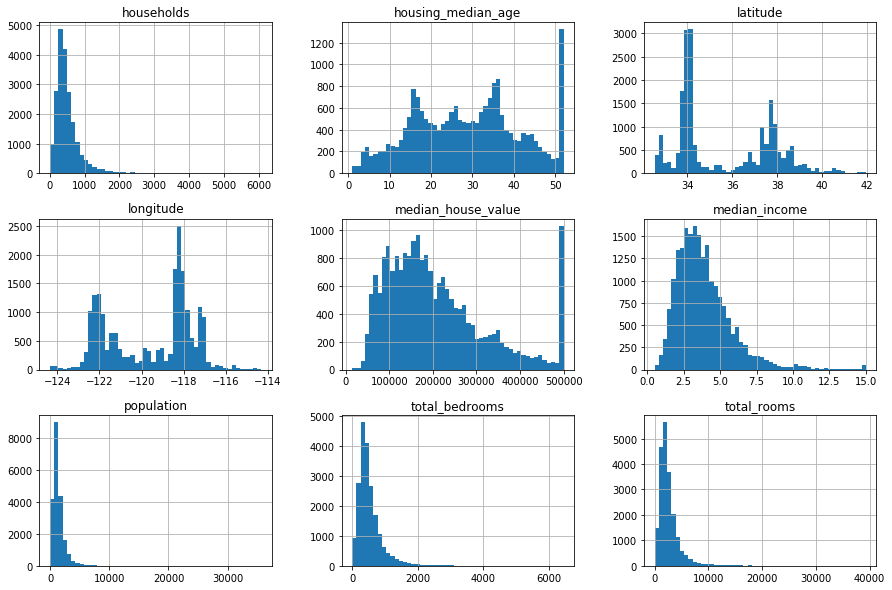

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins = 50, figsize = (15,10))
plt.show()

## Splitting dataset into train set and test set

Creating own splitting function:

In [8]:
import numpy as np

def split_dataset(data, ratio):
    np.random.seed(42)
    shuffle = np.random.permutation(len(data))
    test_size = int(len(data) * ratio)
    test_idx = shuffle[:test_size]
    train_idx = shuffle[test_size:]
    return data.iloc[test_idx], data.iloc[train_idx]

test_set, train_set = split_dataset(dataset, 0.2)
print("Train: ", len(train_set), "\nTest: ", len(test_set))

Train:  16512 
Test:  4128


Another splitting function using hash tables:

In [9]:
import hashlib
def test_check(ident, ratio, hash):
    return hash(np.int64(ident)).digest()[-1] < 256* ratio

def split_dataset_by_id(data, ratio, id_col, hash=hashlib.md5):
    idx = data[id_col]
    in_test = idx.apply(lambda id_: test_check(id_, ratio, hash))
    return data.loc[~in_test], data.loc[in_test]

In [10]:
dataset_with_ids = dataset.reset_index()
train_set, test_set = split_dataset_by_id(dataset_with_ids, 0.2, "index")
print("Train: ", len(train_set), "\nTest: ", len(test_set))

Train:  16362 
Test:  4278


### Splitting with scikit-learn function

In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 42)
print("Train: ", len(train_set), "\nTest: ", len(test_set))

Train:  16512 
Test:  4128


## Startified Sampling

Equal distribution of samples depending on one important variable and its classes.

Creating categories for income median variable:

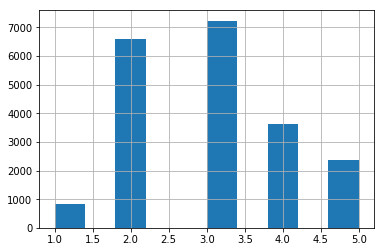

In [24]:
dataset["income_cat"] = np.ceil(dataset["median_income"]/1.5)
dataset["income_cat"].where(dataset["income_cat"]<5, 5.0, inplace = True)

dataset["income_cat"].hist()

Splitting dataset with strat:

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(dataset, dataset["income_cat"]):
    strat_train = dataset.loc[train_idx]
    strat_test = dataset.loc[test_idx]
    
print("Full dataset: ")
print(dataset["income_cat"].value_counts() / len(dataset))

print("\nTrain set: ")
print(strat_train["income_cat"].value_counts() / len(strat_train))

print("\nTest set: ")
print(strat_test["income_cat"].value_counts() / len(strat_test))

Full dataset: 
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Train set: 
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

Test set: 
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


Clearing dataset of class variable:

In [26]:
for set_ in (strat_train, strat_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
strat_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## Data visualisation and exploration

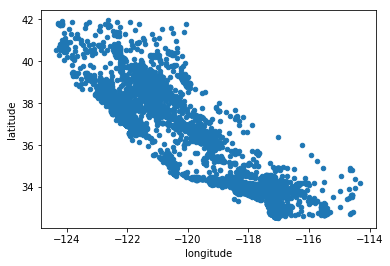

In [28]:
data = strat_train.copy()

data.plot(kind="scatter", x="longitude", y="latitude")

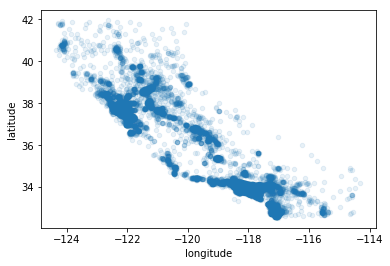

In [29]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

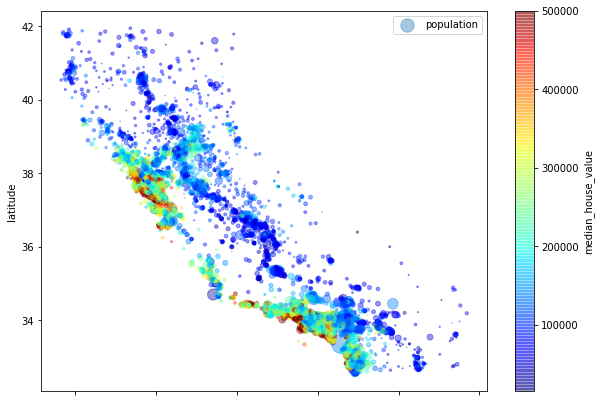

In [30]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=data["population"]/100,
          label="population", figsize=(10,7), c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

## Correlation check

In [31]:
corr_mat = data.corr()
corr_mat["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64